# Tutorial for the application of quantum machine learning in HEP

This tutorial is a quick example of running support-vector machines in classical computers and a simulated quantum computer using a state vector simulator from IBM.
Data samples from the Central Electron Positron Collider (CEPC) are used to demonstrate the performance of the support-vector machine.

```{image} images/ZH_yyqq.png
:width: 400px
:align: center
```
    
The $e^+e^-\rightarrow ZH$ signal and its related backgrounds are utilised for the study where the $H\rightarrow \gamma\gamma$ and $Z\rightarrow q\bar{q}$. They are plenty of events for the signal and backgrounds, but for this tutorial, you can use up o 2k events.

## By the end of the tutorial you will learn the following
- Preparing the dataset from root fills as _NumPy_ arrays
- Understand how to constuct a quantum feature map
- Run a support-vector machines algorithm in classical computers (SVM)
- Run a quantum support-vector machines in simulated computers (QSVM)

This tutorial is based on the results shown in this paper here on __[inspirehep](https://inspirehep.net/literature/2156652)__. Before you run the tutorial, you need to download the following packages by uncommenting the lines in the cell below.

In [31]:
#!pip install scikit-learn
#!pip install scipy
#!pip install qiskit
#!pip install 'qiskit[visualization]'
#!pip install pandas
#!pip install uproot awkward
#!pip3 install qiskit-machine-learning

In [25]:
%run PrepareData.ipynb
%run Variables.ipynb
%run featureMap.ipynb
vardictionary = variables()
nEvents = 200
qubits = 6

# Support-vector Machines

<img style="float: right;" src="images/SVM_margin.png" width="400px" />

Support-vector machines are machine learning algorithms using supervised learning models with associated learning algorithms to analyse data for classification.

Suppose we have a training dataset of $n$ points

$$(\vec{x}_i, y_i) \dots (\vec{x}_n, y_n)$$

if these data points are not linearly separable 

$$k_{ij}(\vec{x}_i,\vec{x}_j) = \left<f(\vec{x}_i), f(\vec{x}_j)\right>$$

There are different form for the $f(\vec{x})$ function
- Radial basis function $f(\vec{x}_i) = e^{-\frac{\vec{x}^2_i}{2\sigma^2}}$
- Polynomial $f(\vec{x}_i) = \left(\gamma\cdot \vec{x}^{T}_i+ r\right)^d; \gamma > 0$
- Sigmoid $f(\vec{x}_i) = \tanh\left(\gamma\cdot \vec{x}^{T}_i+ r\right)$ 

In [26]:
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import normalized_mutual_info_score, roc_curve, auc, confusion_matrix, accuracy_score, roc_auc_score
from sklearn import svm
#from sklearn.datasets import make_blobs

data = preparingData(prossEvent=nEvents, fraction=0.5, dictionary=vardictionary, nqubits=qubits, plot_variable=True, dataType="Classical")
X_train = data['X_train']
y_train = data['y_train']
X_test = data['X_test']
y_test = data['y_test']


svc = svm.SVC(kernel='rbf', probability=True)

clf = svc.fit(X_train, y_train)

y_score = clf.decision_function(X_test)

svm_fpr, svm_tpr, threshold = sklearn.metrics.roc_curve(y_test, y_score)
svm_aruc = sklearn.metrics.auc(svm_fpr, svm_tpr)

print('Area under the curve (AUC):', svm_aruc)

Using the following variables:
 ['minDeltaR_y_j', 'DeltaPhi_yy', 'DeltaP_yy_jj', 'p_yy', 'e_yy', 'recoM_jj']
number of signal: 200 number of background: 200
Area under the curve (AUC): 0.8679471788715486


# Quantum support-vector Machines
In a quantum kernel, a classical feature $\vec{x}$ is mapped to higher dimension Hilbert space like $\left|\phi(\vec{x})\right>$ $\left<\phi(\vec{x})\right|$ in such a way that:
$$k_{ij}(\vec{x}_i, \vec{x}_j) = \left|\left<\phi(\vec{x_i})\right.\left|\phi(\vec{x_j})\right>\right|^2$$
That is what know as the Quantum Kernel estimator. This kernel is based on the idea presneted on this paper https://doi.org/10.1038/s41586-019-0980-2.

In [27]:
from qiskit import Aer, BasicAer
from qiskit.utils import QuantumInstance
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import QuantumKernel

data = preparingData(prossEvent=nEvents, fraction=0.5, dictionary=vardictionary, nqubits=qubits, plot_variable=True, dataType="Quantum")
X_train = data['X_train']
y_train = data['y_train']
X_test = data['X_test']
y_test = data['y_test']

seed = 12345
nshots = 1024
feature_dim = qubits

backend = BasicAer.get_backend("statevector_simulator")

feature_map = FeatureMap(num_qubits=feature_dim, depth=1, degree=1, entanglement='partial', inverse=False)

quantum_instance = QuantumInstance(backend, shots=nshots, seed_simulator=seed, seed_transpiler=seed)

qkernel = QuantumKernel(feature_map=feature_map, quantum_instance=quantum_instance)

qsvm = QSVC(quantum_kernel=qkernel, probability=True)
#print(feature_map)

Using the following variables:
 ['minDeltaR_y_j', 'DeltaPhi_yy', 'DeltaP_yy_jj', 'p_yy', 'e_yy', 'recoM_jj']
number of signal: 200 number of background: 200
*==================================================================================*


In [28]:
qclf = qsvm.fit(X_train, y_train)
y_qscore = qclf.decision_function(X_test)
qsvm_fpr, qsvm_tpr, threshold = sklearn.metrics.roc_curve(y_test, y_qscore)
qsvm_aruc = sklearn.metrics.auc(qsvm_fpr, qsvm_tpr)

print('Area under the curve (AUC):', qsvm_aruc)

Area under the curve (AUC): 0.8510404161664666


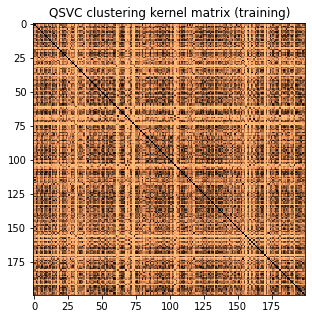

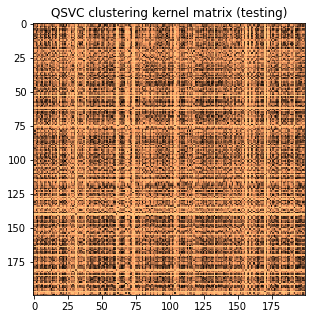

In [29]:
qsvm_kernel_matrix_train = qkernel.evaluate(x_vec=X_train)
qsvm_kernel_matrix_test = qkernel.evaluate(x_vec=X_test,y_vec=X_train)

plt.figure(figsize=(5, 5))
plt.imshow(np.asmatrix(qsvm_kernel_matrix_train), interpolation='nearest', origin='upper', cmap='copper_r')
plt.title("QSVC clustering kernel matrix (training)")
plt.savefig('images/Qsvm_clustering_kernel_matrinx_train.png')
plt.show()

plt.figure(figsize=(5, 5))
plt.imshow(np.asmatrix(qsvm_kernel_matrix_test), interpolation='nearest', origin='upper', cmap='copper_r')
plt.title("QSVC clustering kernel matrix (testing)")
plt.savefig('images/Qsvm_clustering_kernel_matrinx_test.png')
plt.show()

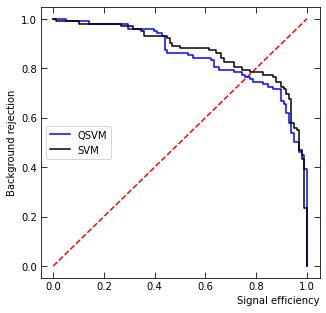

In [30]:
plt.figure(figsize=(5, 5))
ax = plt.gca()
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(qsvm_tpr,1 - qsvm_fpr, 'b', label='QSVM')
plt.plot(svm_tpr,1 - svm_fpr, 'k', label='SVM')
plt.xlabel('Signal efficiency')
plt.ylabel('Background rejection')
#plt.title('ROC curve')
ax.set_xlabel('Signal efficiency', loc='right')
ax.tick_params(axis="x", direction='in', length=6)
ax.tick_params(axis="y", direction='in', length=6)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.legend(loc='best')
plt.savefig('images/ROC.png')
plt.show()